# MLOceanEnsemble with drifters for the Basin


### Classes and modules

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
import datetime
from IPython.display import display
import copy

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "k"
plt.rcParams["text.color"] = "k"
plt.rcParams["axes.labelcolor"] = "k"
plt.rcParams["xtick.color"] = "k"
plt.rcParams["ytick.color"] = "k"

plt.rcParams["image.origin"] = "lower"

from importlib import reload

import pycuda.driver as cuda

GPU Ocean-modules:

In [2]:
from gpuocean.utils import IPythonMagic, Common, WindStress, DrifterPlotHelper, Observation
from gpuocean.SWEsimulators import CDKLM16, ModelErrorKL
from gpuocean.drifters import MLDrifterCollection, GPUDrifterCollection


In [3]:
%cuda_context_handler gpu_ctx

In [4]:
gpu_stream = cuda.Stream()

Basin utils

In [5]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))
from utils.BasinInit import *
from utils.BasinPlot import * 
from utils.BasinParameters import * 
from utils.BasinEnsembleInit import * 

In [6]:
main_drifter_folder = 'drifter_data'
timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
drifter_folder = os.path.join(main_drifter_folder, 'mldrifters_' + timestamp)
sl_drifter_folder = os.path.join(main_drifter_folder, 'sldrifters_' + timestamp)


## ML ensemble

In [7]:
ls = [6, 7, 8, 9]

In [8]:
args_list = []

for l in ls:
    lvl_grid_args = initGridSpecs(l)
    args_list.append( {
        "nx": lvl_grid_args["nx"],
        "ny": lvl_grid_args["ny"],
        "dx": lvl_grid_args["dx"],
        "dy": lvl_grid_args["dy"],
        "gpu_ctx": gpu_ctx,
        "gpu_stream": gpu_stream,
        "boundary_conditions": Common.BoundaryConditions(2,2,2,2)
        } )

In [9]:
data_args_list = []

for l_idx in range(len(ls)):
    data_args_list.append( make_init_steady_state(args_list[l_idx], a=steady_state_bump_a, bump_fractal_dist=steady_state_bump_fractal_dist) )


In [10]:
for l_idx in range(len(ls)):
    print(data_args_list[l_idx]['eta'][2:-2,2:-2].shape)

(128, 64)
(256, 128)
(512, 256)
(1024, 512)


In [11]:
spinup_end_time = 0
end_time = spinup_end_time + 900*4


In [12]:
#ML_Nes = [100, 75, 50, 25] # From Flo. Takes 1m24s to init, 3m13s to run to T=900
ML_Nes = [30, 20, 15, 10] # init: 34s, run: 1m36s


In [13]:
from gpuocean.ensembles import MultiLevelOceanEnsemble

In [14]:
def run_with_drift_dt(drift_dt):
    MLOceanEnsemble = MultiLevelOceanEnsemble.MultiLevelOceanEnsembleCase(ML_Nes, args_list, data_args_list, sample_args, make_sim,
                                init_model_error_basis_args=init_model_error_basis_args, 
                                sim_model_error_basis_args=sim_model_error_basis_args, sim_model_error_timestep=sim_model_error_timestep,
                                init_xorwow_seed=123, init_np_seed=123, sim_xorwow_seed=456, sim_np_seed=456)

    MLOceanEnsemble.stepToObservation(spinup_end_time)

    drifter_ensemble_size = 30
    num_drifters = 25
    MLOceanEnsemble.attachDrifters(drifter_ensemble_size, num_drifters, drift_dt=drift_dt, drift_sensitivity=1)

    t = spinup_end_time
    registration_frequency =  3*60
    while t < end_time:
        tmp_end_time = t + registration_frequency
        MLOceanEnsemble.stepToObservation(tmp_end_time)
        MLOceanEnsemble.registerDrifterPositions()
    
        t = t + registration_frequency

    for obs in MLOceanEnsemble.driftTrajectory:
        obs.nx = MLOceanEnsemble.nxs[-1]
        obs.ny = MLOceanEnsemble.nys[-1]
        obs.domain_size_x = MLOceanEnsemble.nxs[-1]*MLOceanEnsemble.dxs[-1]
        obs.domain_size_y = MLOceanEnsemble.nys[-1]*MLOceanEnsemble.dys[-1]

    return MLOceanEnsemble

In [15]:
MLOceanEnsemble60 = run_with_drift_dt(60)

In [16]:
MLOceanEnsemble180 = run_with_drift_dt(180)

In [17]:
MLOceanEnsemble300 = run_with_drift_dt(300)

In [18]:
MLOceanEnsemble600 = run_with_drift_dt(600)

Comparison

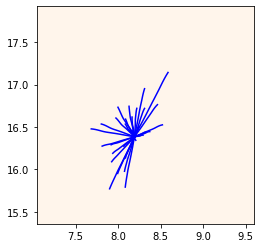

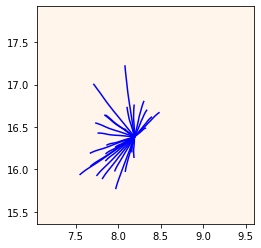

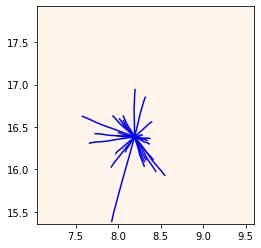

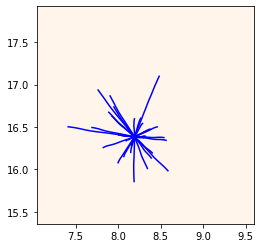

In [20]:
drifter_id = 0

for ens in [MLOceanEnsemble60, MLOceanEnsemble180, MLOceanEnsemble300, MLOceanEnsemble600]:
    drifter_domain = DrifterPlotHelper.domain_around_drifter(MLOceanEnsemble60.driftTrajectory[0], drifter_id=drifter_id, padding_in_km=1)
    ax = DrifterPlotHelper.background_from_mlensemble(MLOceanEnsemble60, background_type="empty", drifter_domain=drifter_domain)
    DrifterPlotHelper.add_ensemble_drifter_on_background(ax, ens.driftTrajectory, drifter_id=drifter_id)

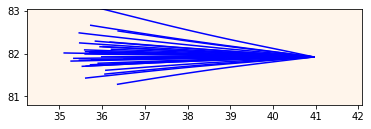

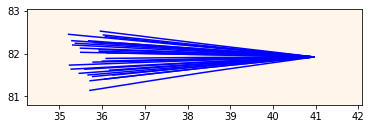

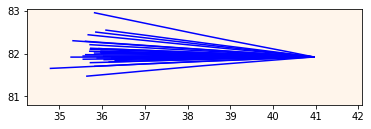

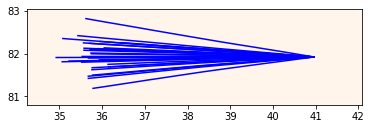

In [26]:
drifter_id = 12

for ens in [MLOceanEnsemble60, MLOceanEnsemble180, MLOceanEnsemble300, MLOceanEnsemble600]:
    drifter_domain = DrifterPlotHelper.domain_around_drifter(MLOceanEnsemble60.driftTrajectory[0], drifter_id=drifter_id, padding_in_km=1)
    ax = DrifterPlotHelper.background_from_mlensemble(MLOceanEnsemble60, background_type="empty", drifter_domain=drifter_domain)
    DrifterPlotHelper.add_ensemble_drifter_on_background(ax, ens.driftTrajectory, drifter_id=drifter_id)